# Predicting Employment of Seniors at Olin

## Daniel Bishop and Mafalda Borges

License: Attribution 4.0 International (CC BY 4.0)

In [2]:
from thinkbayes2 import Suite, Joint
import numpy as np
from itertools import product
import thinkplot
from thinkbayes2 import Pmf, Cdf, Suite, Joint, EvalExponentialPdf, MakePoissonPmf, MakeMixture
from thinkbayes2 import MakeBinomialPmf
from scipy.stats import binom
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
def EvalWeibullPdf(x, lam, k):
    """Computes the Weibull PDF.

    x: value
    lam: parameter lambda in events per unit time
    k: parameter

    returns: float probability density
    """
    arg = (x / lam)
    return k / lam * arg**(k-1) * np.exp(-arg**k)

def EvalWeibullCdf(x, lam, k):
    """Evaluates CDF of the Weibull distribution."""
    arg = (x / lam)
    return 1 - np.exp(-arg**k)

def MakeWeibullPmf(lam, k, high, n=200):
    """Makes a PMF discrete approx to a Weibull distribution.

    lam: parameter lambda in events per unit time
    k: parameter
    high: upper bound
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    xs = np.linspace(0, high, n)
    ps = EvalWeibullPdf(xs, lam, k)
    return Pmf(dict(zip(xs, ps)))

### Problem Statement

Landing the first job after college is extremely important to both the graduates of the institution and the institution itself. For our project we decided to evaluate how quickly seniors at Olin College were able to find employment. We used Bayesian statistics to complete a survival analysis where we evalutated how many months after the beginning of the school year Olin seniors were able to get a job. 

We generated two models and updated them using data provided by the Office of Post-Graduate Planning at Olin College. Both models utilize Weibull distributions which predict the distributions of lifetimes of objects. The Weibull distribution has two parameters know as k and lambda, where k is the shape parameter and lambda is the scale parameter. The inverse CDF of a Weibull distribution is a survival curve. The first model is pure Weibull while the second model is a mixture of Binomial and Weibull.

The first model is more simplistic and easier to implement by not discriminating between the data for before and after graduation. However looking at the raw data shows the rate of finding a job during the school year is significantly different from the months after graduation, so an updated model was created using a binomial distribution to model obtaining a job while in school, and a Weibull distribution for the time afterwards.

In [28]:
class PureWeibull(Suite, Joint):
    """Represents hypotheses about having a job for a student"""
    
    def Likelihood(self, data, hypo):
        """
        lam: paramenter lambda in jobs per month
        k: parameter
        bg = job obtained before graduation
        ag = job obtained after graduation and before December
        nj = no job obtained by December
        agoct = job obtained after graduation and before October
        nj = no job obtained by October
        """
        lam, k = hypo
        if lam == 0:
            return 0
        flag = data
        if flag == 'bg':
            like = EvalWeibullCdf(9, lam, k)
        elif flag == 'ag':
            like = EvalWeibullCdf(16, lam, k) - EvalWeibullCdf(9, lam, k)
        elif flag == 'nj':
            like = 1- EvalWeibullCdf(16, lam, k)
        elif flag == 'agoct':
            like = EvalWeibullCdf(14, lam, k) - EvalWeibullCdf(9, lam, k)
        elif flag == 'njoct':
            like = 1- EvalWeibullCdf(14, lam, k)
        else:
            raise ValueError('Invalid data')
        return like

In [22]:
class BinomialAndWeibull(Suite, Joint):
     def Likelihood(self, data, hypo):
        lam, k, p = hypo
        if lam == 0:
            return 0
        flag, x = data
        if flag == 'eq':
            like = EvalWeibullPdf(x, lam, k)
        elif flag == 'gt':
            like = 1 - EvalWeibullCdf(x, lam, k)
        elif flag == 'lt':
            like = EvalWeibullCdf(x, lam, k)
        elif flag == 'bg': # employed pre-grad
            e, t = x.split("/")
            like = binom.pmf(int(e), int(t), p)
        else:
            raise ValueError('Invalid data')
        return like

These models model the "survival" of unemployment through the months of the school year and after graduation. An assumption is made that every student will eventually get a job. Data is collected once at graduation and again some months afterwards. Thus it is assumed that any students who still do not have a job at the check in period will get a job at a time  after the check in. It is also assumed that once a student gets a job, they never lose it.

The data that the models accept is the times of employment of students, either an exact month or a definition of some period before or after a month. For the first model, the probability of getting a job is strictly Weibull while for the second model the probability of a student getting a job during the school year is modeled as a binomial distribution, and after graduation the model shifts to a Weibull distribution. The second model uses a binomial to show that the chances of being hired during the school year remain constant.

### Data and Formatting

Below is the gathered data with different formatting for each model.

In [29]:
lams1 = np.linspace(0, 30, 101)
ks1 = np.linspace(0, 5, 101)

data16 = []
for i in range(53):
    data16.append(('bg'))
for i in range(9):
    data16.append(('ag'))
for i in range(16):
    data16.append(('nj'))
    
#data for the class of 2016
#53 members of the class had jobs before graduation
#9 members of the class obtained jobs by December
#16 members of the class did not have a job by December
    
data15 = []
for i in range(44):
    data15.append(('bg'))
for i in range(22):
    data15.append(('ag'))
for i in range(16):
    data15.append(('nj'))
    
#data for the class of 2015
#44 members of the class had jobs before graduation
#22 members of the class obtained jobs by December
#16 members of the class did not have a job by December
    
data14 = []
for i in range(41):
    data14.append(('bg'))
for i in range(20):
    data14.append(('ag'))
for i in range(23):
    data14.append(('nj'))
    
#data for the class of 2014
#41 members of the class had jobs before graduation
#20 members of the class obtained jobs by December
#23 members of the class did not have a job by December
    
data13 = []
for i in range(53):
    data13.append(('bg'))
for i in range(6):
    data13.append(('ag'))
for i in range(17):
    data13.append(('nj'))

#data for the class of 2013
#53 members of the class had jobs before graduation
#6 members of the class obtained jobs by December
#17 members of the class did not have a job by December

data12 = []
for i in range(50):
    data12.append(('bg'))
for i in range(4):
    data12.append(('agoct'))
for i in range(15):
    data12.append(('njoct'))

#data for the class of 2012
#50 members of the class had jobs before graduation
#4 members of the class obtained jobs by October
#15 members of the class did not have a job by October
    
dataAll = data16 + data15 + data14 + data13 + data12

#The combined dataset for all years

suiteAll = PureWeibull(product(lams1,ks1))
suiteAll.UpdateSet(dataAll)

1.5283691776746342e-158

In [24]:
# Use binomial for survival of unemployment before graduation
# Use Weibull for survival of unemployment after graduation

lams = np.linspace(0, 30, 101)
ks = np.linspace(0, 5, 10)
p = np.linspace(0, 1, 20)
# class of 2012 data
# 69 students
# 50 employed at grad
# 4 more employed after 5 months
# 13 unemployed at 5 months
d_2012 = {("lt", 5): 4, ("gt", 5): 13, ("bg", "50/69"): 1}
# class of 2013 data
# 76 students
# 53 employed at grad
# 6 more employed after 7 months
# 17 unemployed at 7 months
d_2013 = {("lt", 7): 6, ("gt", 7): 17, ("bg", "53/76"): 1}
# class of 2014 data
# 84 students
# 41 employed at grad
# 20 more employed after 7 months
# 23 unemployed at 7 months
d_2014 = {("lt", 7): 20, ("gt", 7): 23, ("bg", "41/84"): 1}
# class of 2015 data
# 82 students
# 44 employed at grad
# 22 more employed after 7 months
# 16 unemployed at 7 months
d_2015 = {("lt", 7): 22, ("gt", 7): 16, ("bg", "44/82"): 1}
# class of 2016 data
# 78 students
# 53 employed at grad
# 9 more employed after 7 months
# 16 unemployed at 7 months
d_2016 = {("lt", 7): 9, ("gt", 7): 16, ("bg", "53/78"): 1}

distr = BinomialAndWeibull(product(lams, ks, p))
ds = []
for x in d_2012:
    for _ in range(d_2012[x]):
        ds.append(x)
for x in d_2013:
    for _ in range(d_2013[x]):
        ds.append(x)
for x in d_2014:
    for _ in range(d_2014[x]):
        ds.append(x)
for x in d_2015:
    for _ in range(d_2015[x]):
        ds.append(x)
for x in d_2016:
    for _ in range(d_2016[x]):
        ds.append(x)
distr.UpdateSet(ds)

3.829063822745909e-54

### Marginal Distributions

After updating our models with the data set, we plotted the marginal distributions which represent k's and lambdas.

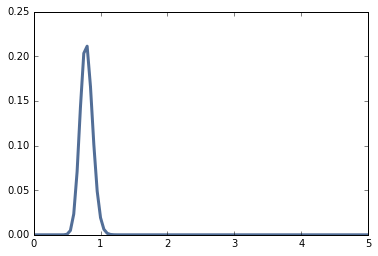

In [25]:
pmf_kAll = suiteAll.Marginal(1)
thinkplot.Pdf(pmf_kAll)

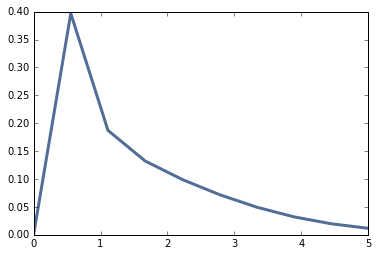

In [26]:
pmf_k = distr.Marginal(1)
thinkplot.Pdf(pmf_k)

The second model is more likely to have larger k values than the first model which indicates a delayed spike in employment rates.

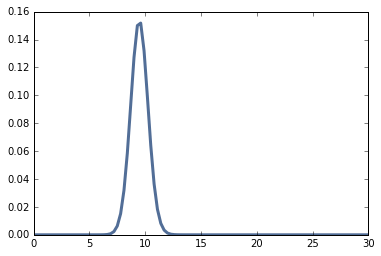

In [30]:
pmf_lamAll = suiteAll.Marginal(0)
thinkplot.Pdf(pmf_lamAll)

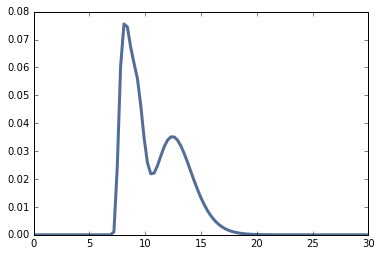

In [11]:
pmf_lam = distr.Marginal(0)
thinkplot.Pdf(pmf_lam)

The second model once again has a higher potential for a larger lambda which indicates a larger spread of employment probabilities over time. 

Since the second model assumes a constant probability of getting a job during the school year, it has an extra hypothesis value 'p'.

0.63157894736842102

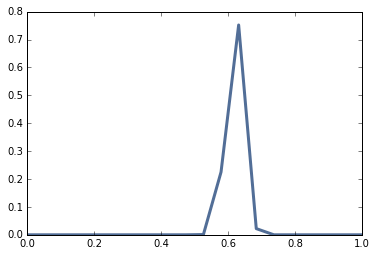

In [31]:
pmf_p = distr.Marginal(2)
thinkplot.Pdf(pmf_p)
pmf_p.MAP()

Here we see that 'p' is most likely somewhere around 63%.

### Predictions

Now that we have trained our models, we use them to generate predictions of employment before different time points.

In [13]:
prob = 0
for hypo in suiteAll:
    lam, k = hypo
    prob += suiteAll[hypo] * EvalWeibullCdf(9, lam, k)
print("Probability at 9 months", prob)

('Probability at 9 months', 0.61687263105965351)


In [14]:
prob = 0
for hypo in distr:
    lam, k, p = hypo
    prob += distr[hypo] * p
    
print("Probability of a student being employed at 9 months:", prob)

('Probability of a student being employed at 9 months:', 0.62081571046568529)


At the nine month mark (graduation), both models agree that the probability of a student being employed is about 62%.

In [39]:
prob = 0
for hypo in suiteAll:
    lam, k = hypo
    prob += suiteAll[hypo] * EvalWeibullCdf(16, lam, k)
print("Probability at 16 months", prob)

('Probability at 16 months', 0.77915966251511115)


In [40]:
prob = 0
for hypo in distr:
    lam, k, p = hypo
    prob += distr[hypo] * p
    prob += distr[hypo] * (EvalWeibullCdf(16, lam, k) - EvalWeibullCdf(9, lam, k))
    
print("Probability of a student being employed at 16 months:", prob)

('Probability of a student being employed at 16 months:', 0.8294437887194428)


Seven months after graduation, the models begin to diverge, with model 2 being more optimistic about student employment.

In [17]:
prob = 0
for hypo in suiteAll:
    lam, k = hypo
    prob += suiteAll[hypo] * EvalWeibullCdf(24, lam, k)
print("Probability at 24 months", prob)

('Probability at 24 months', 0.87446442416661763)


In [18]:
prob = 0
for hypo in distr:
    lam, k, p = hypo
    prob += distr[hypo] * p
    prob += distr[hypo] * (EvalWeibullCdf(24, lam, k) - EvalWeibullCdf(9, lam, k))
    
print("Probability of a student being employed at 24 months:", prob)

('Probability of a student being employed at 24 months:', 0.9459557171796027)


After 24 months, the models maintain their offset between predictions, with model 2 predicting 94% employment while model 1 predicts 87%.

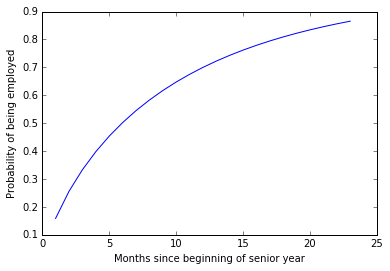

In [19]:
tot = []
for i in range(24):
    prob = 0
    for hypo in suiteAll:
        lam, k = hypo
        prob += suiteAll[hypo] * EvalWeibullCdf(i, lam, k)
    tot.append(prob)

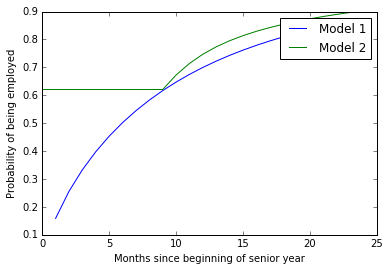

In [38]:
ps = []
for i in range(24):
    prob = 0
    for hypo in distr:
        lam, k, p = hypo
        if (i <= 9):
            prob += distr[hypo] * p
        else:
            prob += distr[hypo] * p
            prob += distr[hypo] * (EvalWeibullCdf(i, lam, k) - EvalWeibullCdf(9, lam, k))
    ps.append(prob)
plt.xlabel("Months since beginning of senior year")
plt.ylabel("Probability of being employed")
line1, = plt.plot(tot, label="Model 1")
line2, = plt.plot(ps, label='Model 2')
plt.legend(handles=[line1, line2])

### Results and Analysis

The figure above shows the probability of a student having a job at any given month up to 2 years from the beginning of their senior year. In the first model, the probability of employment increases as the school year goes on. The second model maintains a constant probability of employment through the school year.  

At graduation, both models predict roughly the same probability of having a job. However, after graduation, model 2 predicts a higher employment rate.

Model 1 predicts that 7 months after graduation 78% of students will have jobs, while model 2 predicts that 83% will.  

We tested this prediction against the data for the class of 2016. At the checkin 7 months after graduation, 79.4% of the class was employed. This closely matches the prediction of model 1, while model 2 was overoptimistic. 

Model 2 continues to be more optimistic than model 1 up to 24 months since the start of the school year. Because we lack data reaching this far out after graduation, our models become too uncertain for accurate predictions. Possible reasons for model 2's optimism include the disregard for guaranteed unemployment from graduate school as well as those students who never receive jobs.  

### Future Work

Possible future work would be to expand the dataset to draw from further checkins, and include more factors such as graduate school, travel, job-search, and others.